# Goal
The goal of this script is to take the output of `genome_to_tetramer.ipynb` and transform it into a tSNE and a linear map on the genome clustered by interesting frequency changes. Here I demonstrate on Staph Aureus GCF_000013425.1_ASM1342v1_genomic.fna from https://www.ncbi.nlm.nih.gov/genome/154?genome_assembly_id=299272.

In [1]:
# imports
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import numpy as np
from numpy import reshape
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches

pd.options.display.max_rows = 999
# https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html

np.set_printoptions(linewidth=100)
%matplotlib inline

## Read in data

In [3]:
df = pd.read_csv("./tetraFrequency.csv")
df.head()

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.000379,0.000341,0.000571,0.000343,0.000480,0.000366,0.000000,0.000609,0.000567,0.000547,...,0.00013,0.000110,0.000265,0.000075,0.000457,0.000327,0.000431,0.000239,0.000367,0.000257
1,0.000617,0.000511,0.000428,0.000441,0.000336,0.000244,0.000215,0.000338,0.001078,0.000456,...,0.00039,0.000166,0.000221,0.000377,0.000366,0.000187,0.000304,0.000287,0.000229,0.000257
2,0.000427,0.000568,0.000333,0.000392,0.000480,0.000244,0.000215,0.000609,0.000681,0.000091,...,0.00013,0.000331,0.000132,0.000301,0.000183,0.000140,0.000329,0.000287,0.000138,0.000163
3,0.000759,0.000511,0.000428,0.000662,0.000288,0.000244,0.000644,0.000203,0.000511,0.000182,...,0.00013,0.000497,0.000442,0.000151,0.000457,0.000187,0.000329,0.000191,0.000183,0.000187
4,0.000379,0.000341,0.000714,0.000368,0.000240,0.000122,0.000859,0.000271,0.000511,0.000365,...,0.00026,0.000221,0.000309,0.000151,0.000366,0.000233,0.000304,0.000048,0.000321,0.000093


## Z-score normalize the columns

In [8]:
df = df.apply(func=lambda x: (x-np.mean(x))/np.std(x), axis=0)
df.head()

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.124643,-0.080492,0.987709,-0.090621,0.791130,0.045423,-1.653891,1.471513,0.800340,0.867650,...,-0.911669,-0.959123,-0.589869,-1.371295,0.477588,-0.136790,0.625979,-0.547320,0.072913,-0.497431
1,1.310943,0.925719,0.336343,0.703296,-0.115237,-0.449317,-0.651823,-0.094659,2.719660,0.456627,...,0.144736,-0.741956,-0.880883,0.109583,0.053115,-0.830412,-0.413389,-0.320129,-0.730552,-0.497431
2,0.361903,1.261123,-0.097901,0.306338,0.791130,-0.449317,-0.651823,1.471513,1.226856,-1.187464,...,-0.911669,-0.090454,-1.462912,-0.260637,-0.795830,-1.061619,-0.205516,-0.320129,-1.266195,-0.973191
3,2.022723,0.925719,0.336343,2.489608,-0.417360,-0.449317,1.352311,-0.877745,0.587083,-0.776441,...,-0.911669,0.561047,0.574189,-1.001076,0.477588,-0.830412,-0.205516,-0.774511,-0.998373,-0.854251
4,0.124643,-0.080492,1.639076,0.107858,-0.719482,-0.944057,2.354379,-0.486202,0.587083,0.045604,...,-0.383466,-0.524789,-0.298855,-1.001076,0.053115,-0.599205,-0.413389,-1.456083,-0.194909,-1.330011


count    2.821000e+03
mean     1.222090e-14
std      1.000177e+00
min     -1.773436e+00
25%     -7.057664e-01
50%     -1.126165e-01
75%      5.991634e-01
max      5.462992e+00
Name: AAAA, dtype: float64

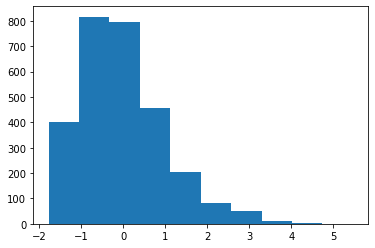

In [11]:
# QC to make sure I did the right axis for normalization
plt.hist(df['AAAA'])
df['AAAA'].describe()

## Perform PCA 

In [57]:
pca = PCA(n_components=20)
pca.fit(df.values.T)
PCAdata = pca.components_.T
PCAdata.shape

(2821, 20)

<BarContainer object of 20 artists>

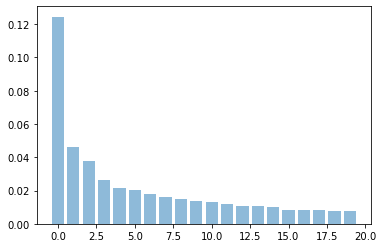

In [58]:
exp_var_pca = pca.explained_variance_ratio_
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')

## Perform tSNE on PCA components
In theory we should mess with the `perplexity` but I'm lazy and wont be doing that yet.

In [59]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)

In [60]:
z = tsne.fit_transform(PCAdata)

/home/mkozubov/miniconda3/envs/stats/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mkozubov/miniconda3/envs/stats/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2821 samples in 0.001s...
[t-SNE] Computed neighbors for 2821 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2821
[t-SNE] Computed conditional probabilities for sample 2000 / 2821
[t-SNE] Computed conditional probabilities for sample 2821 / 2821
[t-SNE] Mean sigma: 0.024083
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.877365
[t-SNE] KL divergence after 1000 iterations: 2.567920


## Use kmeans clustering to find patterns
There are ways to see what the optimal number of clusters is, but here I'm going by eye.

In [64]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(PCAdata)
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

[Text(0.5, 1.0, 'Staph Aureus Dimension Reduction')]

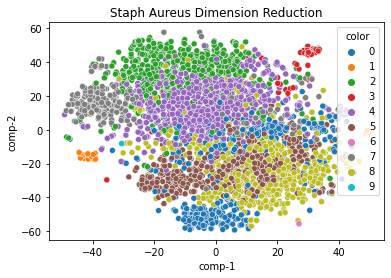

In [65]:
dfSNE = pd.DataFrame()
dfSNE['color'] = kmeans.labels_
dfSNE["comp-1"] = z[:,0]
dfSNE["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", 
                hue='color', palette="tab10",
                       data=dfSNE).set(title="Staph Aureus Dimension Reduction")

Text(0.5, 1.0, 'Colorful Genome Reference')

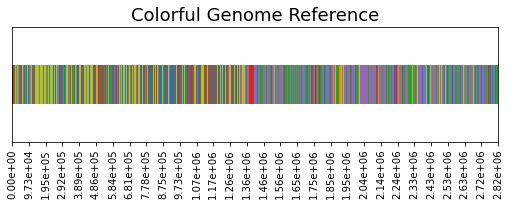

In [74]:
##############
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Colorful Genome Panel
##############
chunkSize = 1000
figureHeight = 5
figureWidth = 8
palette = sns.color_palette("tab10")[:len(set(dfSNE.color))]


genomePanelHeight = 2 ; relativegenomePanelHeight = genomePanelHeight/figureHeight
genomePanelWidth = 9 ; relativegenomePanelWidth = genomePanelWidth/figureWidth

genomePanel = plt.axes([0.05, 0.5,relativegenomePanelWidth,relativegenomePanelHeight])
genomePanel.tick_params(bottom=True, labelbottom=True,
    left=False, labelleft=False,
    right=False, labelright=False,
    top=False, labeltop=False)

n_chunk = dfSNE.shape[0]
for i in range(0,n_chunk):
    left = i*chunkSize
    rectangleHeight = 1
    rectangleWidth = chunkSize
    color = palette[dfSNE['color'].iloc[i]]
    rectangle=mplpatches.Rectangle([left,1],
                                   rectangleWidth,
                                   rectangleHeight,
                                   facecolor=color,
                                   edgecolor='black',
                                   linewidth=0)
    genomePanel.add_patch(rectangle)

genomePanel.set_ylim([0,3])
genomePanel.set_xlim([0,chunkSize*n_chunk])

xmin = 0
xmax = chunkSize*n_chunk
genomePanel.set_xticks([x for x in np.linspace(xmin,xmax,30)])
genomePanel.set_xticklabels(["{:.2e}".format( round(x,0) ) for x in np.linspace(xmin,xmax,30)], rotation=90)
genomePanel.set_title('Colorful Genome Reference', fontdict={'fontsize':18})

##############

# Conclusion
It appears that orange is consistently labelled rRNA. 

The large red near 1.36e6 is "hyperosmolarity resistance protein Ebh", a large multispecies protein that confers resistance against Complement cascade. Interesting that it is read as being rather different from the rest of Staph.

The other little island of red to the right of the genome is probably "LPXTG-anchored DUF1542 repeat protein FmtB" which seems to be yet another surface protein. This one seems important for biofilm formation, so maybe it is possible that it is another immune evading protein. Maybe that is what red is: immune evasion. More research would be needed to conclude anything like that.

It is very interesting that the genome seems segregated into two regions, up and downstream.